<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/ThermoclineEndMemberDefinition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4 MB 5.0 MB/s 


In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-08-19 21:21:04--  https://docs.google.com/uc?export=download&confirm=ZO9g&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 173.194.215.102, 173.194.215.100, 173.194.215.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-4o-docs.googleusercontent.com/docs/securesc/nhevaj4eqcm2ji0kmle1uii9l5cnr1tv/ar7e3ms379pi64p343nlv8m18jh9jj66/1629408000000/06203730782251856755/15433631866049852156Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-08-19 21:21:04--  https://doc-0g-4o-docs.googleusercontent.com/docs/securesc/nhevaj4eqcm2ji0kmle1uii9l5cnr1tv/ar7e3ms379pi64p343nlv8m18jh9jj66/1629408000000/06203730782251856755/15433631866049852156Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-0g-4o-docs.googleusercontent.com (doc-0g-4o-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connec

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [7]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temp'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])
df["sigma2"] = gsw.sigma2(SA=df["absolute_salinity"],CT=df["conservative_temp"])
df["sigma4"] = gsw.sigma4(SA=df["absolute_salinity"],CT=df["conservative_temp"])

[23.9  23.91 23.92 23.93 23.94 23.95 23.96 23.97 23.98 23.99]
PSUW


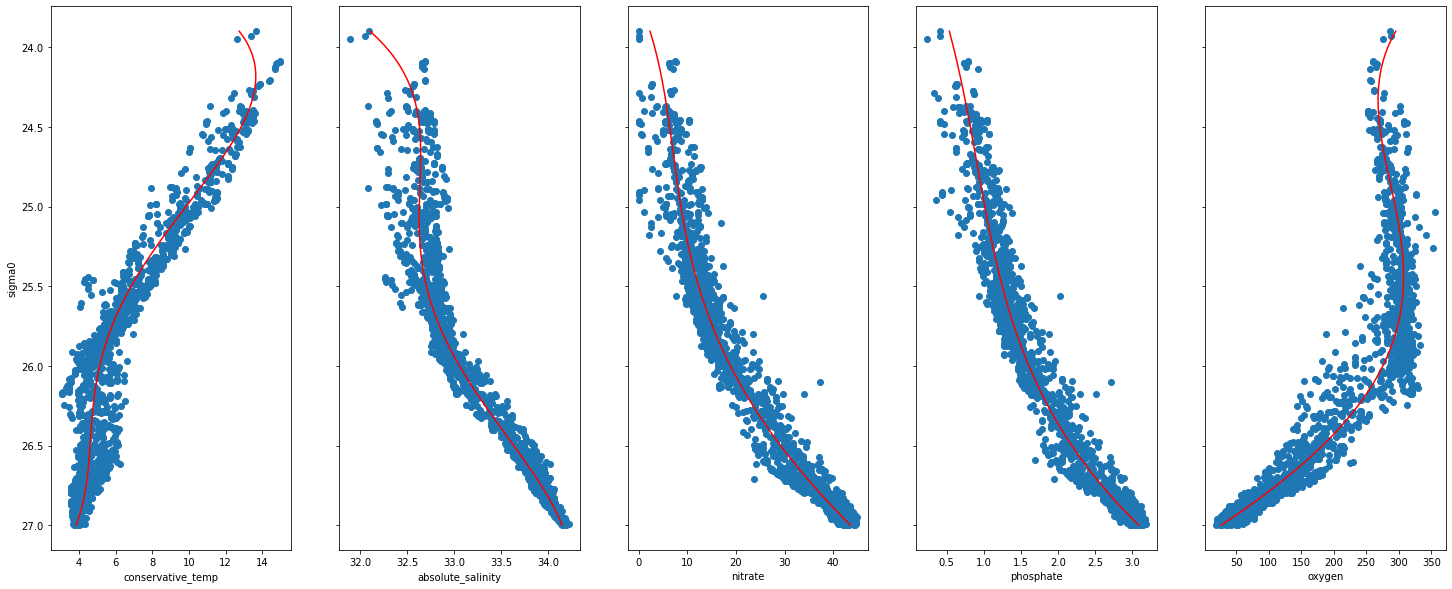

[21.91 21.92 21.93 21.94 21.95 21.96 21.97 21.98 21.99 22.  ]
ENPCW


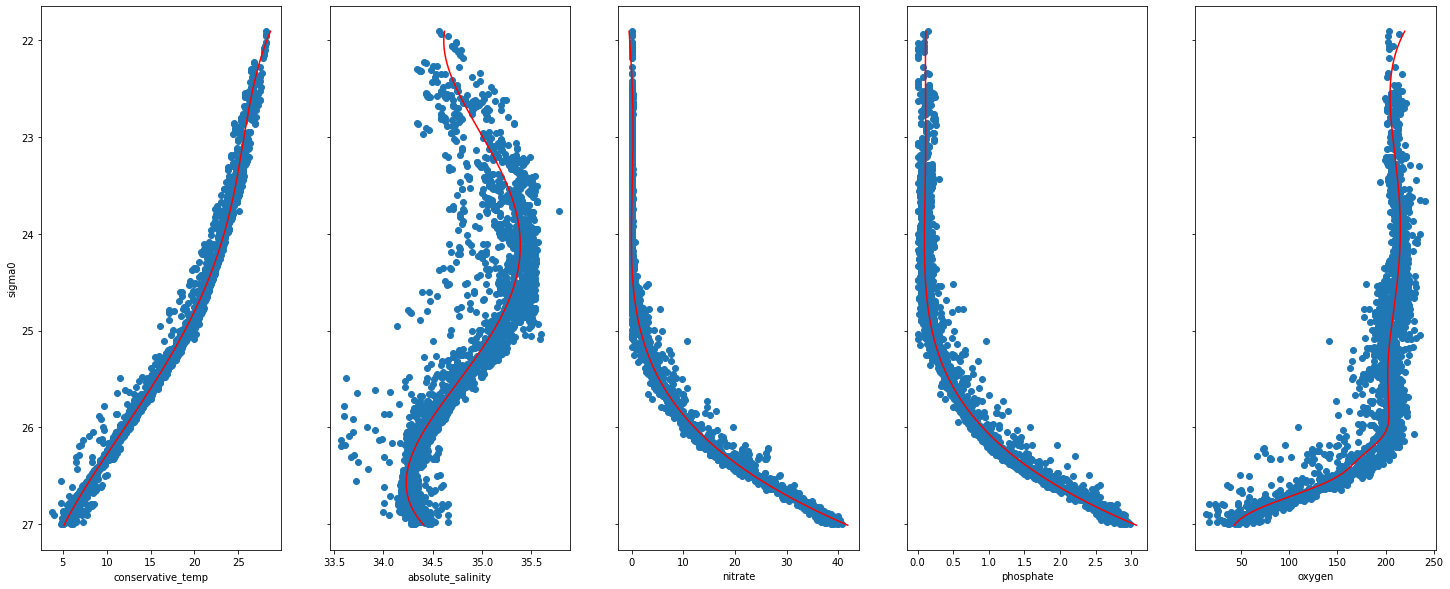

[21.01 21.02 21.03 21.04 21.05 21.06 21.07 21.08 21.09 21.1 ]
ESSW


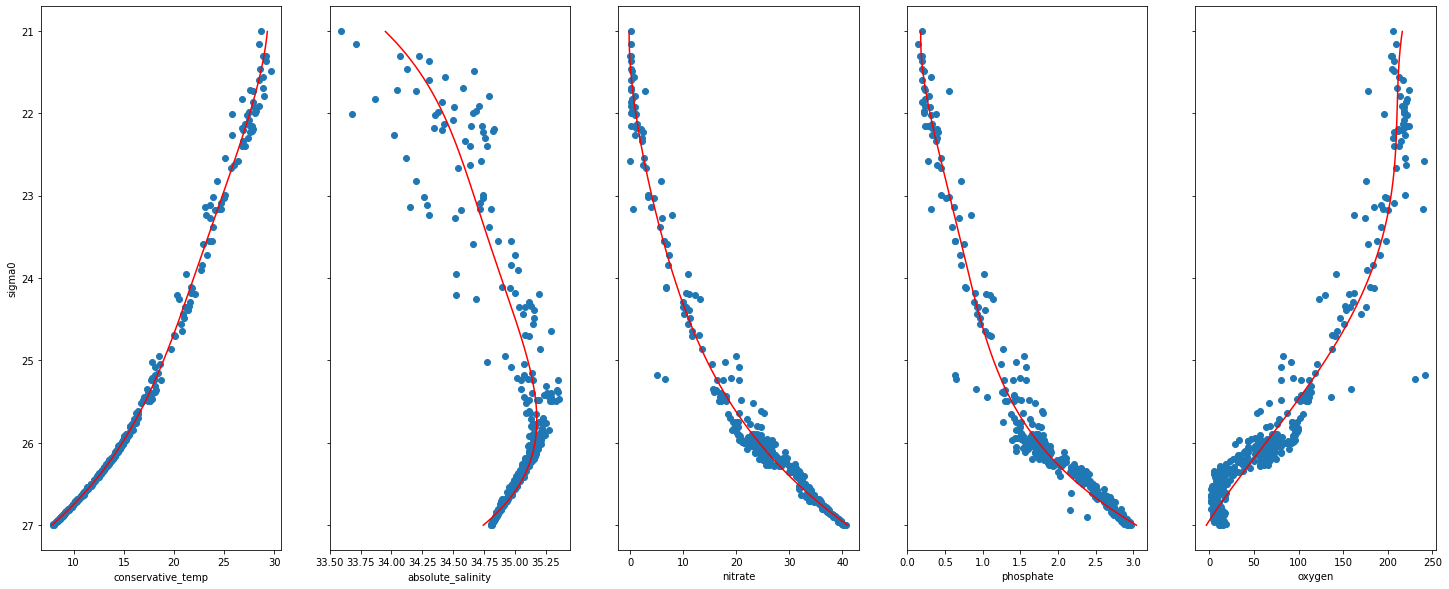

[23.9  23.91 23.92 23.93 23.94 23.95 23.96 23.97 23.98 23.99]
SPCW


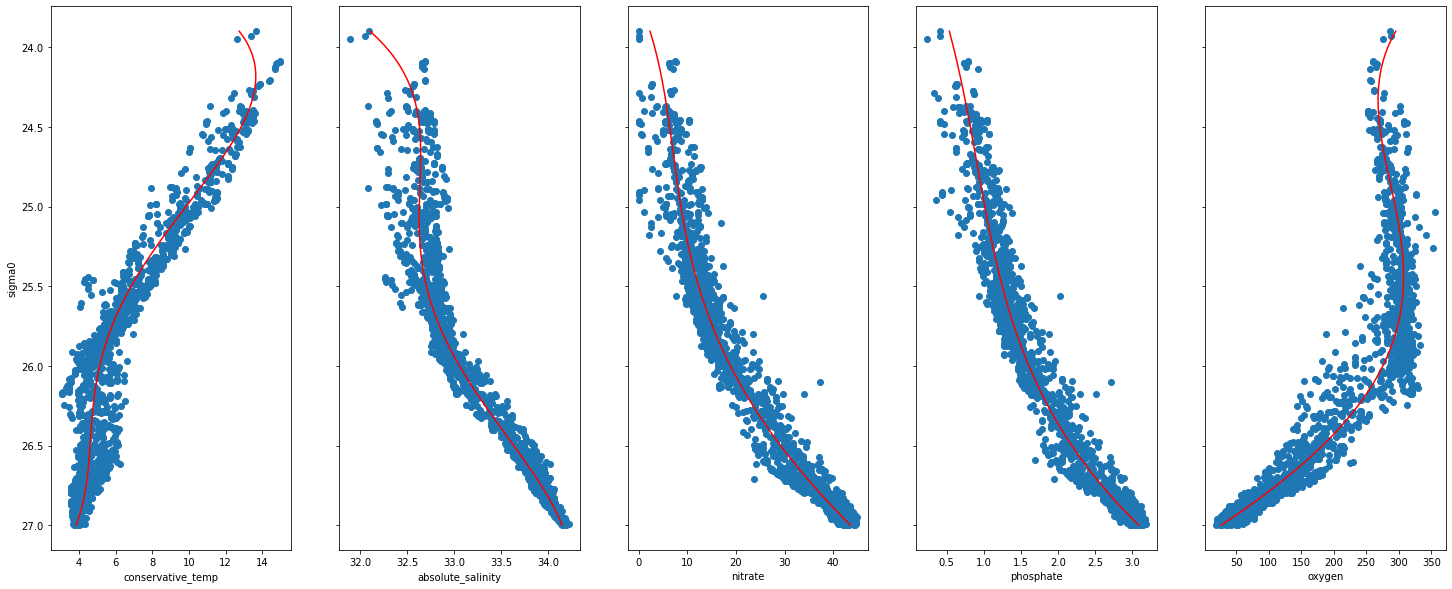

In [19]:
import scipy
import scipy.interpolate
import numpy as np
from collections import OrderedDict, defaultdict
from matplotlib import pyplot as plt

STEP_SIZE = 0.01
FEATURES_TO_INTERPOLATE = ["conservative_temp", "absolute_salinity",
                           "nitrate", "phosphate", "oxygen"]

def get_interpolation(x,y,s,k,intervals):
  return scipy.interpolate.UnivariateSpline(
      x=x, y=y, k=k, s=s)(intervals)


def get_avg_y_per_x(x,y):
  #deduplication
  x_to_ys = defaultdict(list)
  for an_x, a_y in zip(x, y):
    x_to_ys[an_x].append(a_y)

  ys = []
  xs = []
  for x in sorted(x_to_ys.keys()):
    xs.append(x)
    ys.append(np.median(x_to_ys[x]))
  
  return np.array(xs), np.array(ys)


def filter_df_for_range_and_interpolate(watertype_name, big_df,
                                        s, k,
                                        depth_min=-np.inf, depth_max=np.inf,
                                        lat_min=-np.inf, lat_max=np.inf,
                                        lon_min=-np.inf, lon_max=np.inf,
                                        sig0_min=-np.inf, sig0_max=np.inf, ):
  filtered_df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)
     & (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)
     & (df['sigma0'] >= sig0_min) & (df['sigma0'] <= sig0_max)
     & (df['depth'] >= depth_min) & (df['depth'] <= depth_max) ]
  
  orig_x = np.array(filtered_df['sigma0'])
  
  x_min = int(np.ceil(min(orig_x)/STEP_SIZE))*STEP_SIZE
  x_max = int(max(orig_x)/STEP_SIZE)*STEP_SIZE
  intervals = np.array([x_min+(step*STEP_SIZE) for step in 
                       range(int((x_max-x_min)/STEP_SIZE) + 2)])
  print(intervals[:10])

  interpolated_feature_dict = OrderedDict()
  interpolated_feature_dict["sigma0"] = intervals

  fig, ax = plt.subplots(nrows=1, ncols=len(FEATURES_TO_INTERPOLATE),
                         sharey=True,
                         figsize=(len(FEATURES_TO_INTERPOLATE)*5, 10))
  for idx,feature_name in enumerate(FEATURES_TO_INTERPOLATE):
    orig_y = np.array(filtered_df[feature_name])
    #filter out nans
    filt_x = orig_x[np.isfinite(orig_y)]
    filt_y = orig_y[np.isfinite(orig_y)]

    x,y = get_avg_y_per_x(x=filt_x,y=filt_y)
    
    interpolated_features = get_interpolation(x=x,
        y=y,
        s=s,
        k=k,
        intervals=intervals)
    
    interpolated_feature_dict[feature_name] = interpolated_features
    plt.sca(ax[idx])
    plt.xlabel(feature_name)
    #plt.scatter(orig_y, orig_x)
    plt.scatter(y, x)
    plt.plot(interpolated_features, intervals, color="red")

  plt.sca(ax[0])
  plt.ylabel("sigma0")
  plt.ylim(plt.ylim()[1], plt.ylim()[0])
  print(watertype_name)
  plt.show()

  pandas.DataFrame(interpolated_feature_dict).to_csv(watertype_name+".csv", index=False)

#big_df refers to the glodap df.
#s controls smoothing of the spline
#k controls the degree of the spline. k=4 is a quartic spline.
# Cubic spline seemed less reliable

filter_df_for_range_and_interpolate(watertype_name="PSUW",
                                    big_df=df, lat_min=50, lat_max=58,
                                    lon_min=-155, lon_max=-140,
                                    sig0_min=21, sig0_max=27,
                                    s=1000000,
                                    k=4
                                    )

filter_df_for_range_and_interpolate(watertype_name="ENPCW",
                                    big_df=df, lat_min=16, lat_max=26,
                                    lon_min=-170, lon_max=-140,
                                    sig0_min=21, sig0_max=27,
                                    s=1000000*0.5,
                                    k=4
                                    )

filter_df_for_range_and_interpolate(watertype_name="ESSW",
                                    big_df=df, lat_min=-5, lat_max=5,
                                    lon_min=-90, lon_max=-80,
                                    sig0_min=21, sig0_max=27,
                                    s=1000000,
                                    k=4
                                    )

filter_df_for_range_and_interpolate(watertype_name="SPCW",
                                    big_df=df, lat_min=50, lat_max=58,
                                    lon_min=-155, lon_max=-140,
                                    sig0_min=21, sig0_max=27,
                                    s=1000000,
                                    k=4
                                    )
